Computing p-values from variable importance
=====================================

This is an *VariantSpark* example notebook.


One of the main applications of VariantSpark is discovery of genomic variants correlated with a response variable (e.g. case vs control) using random forest gini importance.

The `chr22_1000.vcf` is a very small sample of the chromosome 22 VCF file from the 1000 Genomes Project.

`chr22-labels-hail.csv` is a CSV file with sample response variables (labels). In fact the labels directly represent the number of alternative alleles for each sample at a specific genomic position. E.g.: column x22_16050408 has labels derived from variants in chromosome 22 position 16050408. We would expect then that position 22:16050408 in the VCF file is strongly correlated with the label x22_16050408.

Both data sets are located in the `..\data` directory.

This notebook demonstrates how to correctly get the p-values for each of the SNPs and their significant ones based on a *VariantSpark* model.

In [ ]:
Step 1: Create a `HailContext` using `SparkContext` object (here injected as `sc`):

In [7]:
import hail as hl
import varspark.hail as vshl
vshl.init()

using variant-spark jar at '/Users/reg032/workspace/VariantSpark/target/variant-spark_2.11-0.5.0-a0-dev0-all.jar'
22/06/08 09:29:45 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/06/08 09:29:46 WARN Hail: This Hail JAR was compiled for Spark 3.1.1, running with Spark 3.1.2.
  Compatibility is not guaranteed.
22/06/08 09:29:47 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
Running on Apache Spark version 3.1.2
SparkUI available at http://192.168.86.23:4041
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.74-0c3a74d12093
LOGGING: writing to /Users/reg032/workspace/VariantSpark/examples/hail-20220608-0929-0.2.74-0

In [8]:
#from varspark.stats.lfdr import LocalFdr
#from varspark.hail.lfdrvs import LocalFdrVs

In [ ]:
Step 2: Load Hail variant dataset  `vds` from a sample `.vcf` file.

In [ ]:
vds = hl.import_vcf('../data/chr22_1000.vcf')

In [ ]:
Step 3: Load labels into Hail table `labels`.

In [ ]:
labels = hl.import_table('../data/chr22-labels-hail.csv', impute = True, delimiter=",").key_by('sample')

In [ ]:
Step 4: Annotate dataset samples with labels.

In [ ]:
vds = vds.annotate_cols(label = labels[vds.s])
vds.cols().show(3)

In [ ]:
Step 5: Build the random forest model with `label.x22_16050408` as the respose variable.

In [ ]:
rf_model = vshl.random_forest_model(y=vds.label['x22_16050408'],
                x=vds.GT.n_alt_alleles(), seed = 13, mtry_fraction = 0.05, min_node_size = 5, max_depth = 10)
rf_model.fit_trees(300, 50)

In [9]:
Step 6: Display the results: print OOB error calculated variable importance.

2022-06-08 09:29:53 Hail: WARN: Name collision: field 'sample' already in object dict. 
  This field must be referenced with __getitem__ syntax: obj['sample']
2022-06-08 09:29:53 Hail: INFO: Reading table to impute column types
2022-06-08 09:29:58 Hail: INFO: Finished type imputation            (0 + 1) / 1]
  Loading field 'sample' as type str (imputed)
  Loading field 'x22_16050408' as type int32 (imputed)
  Loading field 'x22_16050612' as type str (imputed)
  Loading field 'x22_16050678' as type str (imputed)
  Loading field 'x22_16050984' as type int32 (imputed)
  Loading field 'x22_16051107' as type int32 (imputed)
  Loading field 'x22_16051249' as type int32 (imputed)
  Loading field 'x22_16051347' as type int32 (imputed)
  Loading field 'x22_16051453' as type int32 (imputed)
  Loading field 'x22_16051477' as type int32 (imputed)
  Loading field 'x22_16051480' as type int32 (imputed)
2022-06-08 09:29:58 Hail: WARN: cols(): Resulting column table is sorted by 'col_key'.
    To pres

+-----------+--------------------+--------------------+--------------------+
| s         | label.x22_16050408 | label.x22_16050612 | label.x22_16050678 |
+-----------+--------------------+--------------------+--------------------+
| str       |              int32 | str                | str                |
+-----------+--------------------+--------------------+--------------------+
| "HG00096" |                  0 | "hahaha"           | "heheh"            |
| "HG00097" |                  1 | "ala ma"           | "1"                |
| "HG00099" |                  1 | "1"                | "1"                |
+-----------+--------------------+--------------------+--------------------+

+--------------------+--------------------+--------------------+
| label.x22_16050984 | label.x22_16051107 | label.x22_16051249 |
+--------------------+--------------------+--------------------+
|              int32 |              int32 |              int32 |
+--------------------+--------------------+--------------------+
|                  0 |                  0 |                  0 |
|                  0 |                  1 |                  1 |
|                  0 |                  1 |                  1 |
+--------------------+--------------------+--------------------+

+--------------------+--------------------+--------------------+
| label.x22_16051347 | label.x22_16051453 | label.x22_16051477 |
+--------------------+--------------------+--------------------+
|              int32 |              int32 |              int32 |
+--------------------+--------------------+--------------------+
|                  0 |                  0 |                  0 |
|                  1 |                  1 |                  0 |
|                  1 |                  1 |                  0 |
+--------------------+--------------------+--------------------+

+--------------------+
| label.x22_16051480 |
+--------------------+
|              int32 |
+--------------------+
|                  0 |
|                  1 |
|                  1 |
+--------------------+
showing top 3 rows

2022-06-08 09:30:04 Hail: INFO: Coerced almost-sorted dataset
2022-06-08 09:30:23 Hail: INFO: Coerced sorted dataset=======>      (8 + 1) / 9]


In [ ]:
print("OOB error: %s" % rf_model.oob_error())
impTable = rf_model.variable_importance()
impTable.order_by(hl.desc(impTable.importance)).show(10)

In [ ]:
Step 7: Get the fdr calculation class from the VariantSpark model

In [11]:
fdrCalc = rf_model.get_lfdr()

2022-06-08 09:30:28 Hail: INFO: Coerced sorted dataset


In [ ]:
Step 8: Visualize the distribution of importances based on the number of splits for a variable to be included. These distributions can take many shapes but the goal here is that there is one big *unimodal distribution*. In this case, setting the threshold to `2` looks the best.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


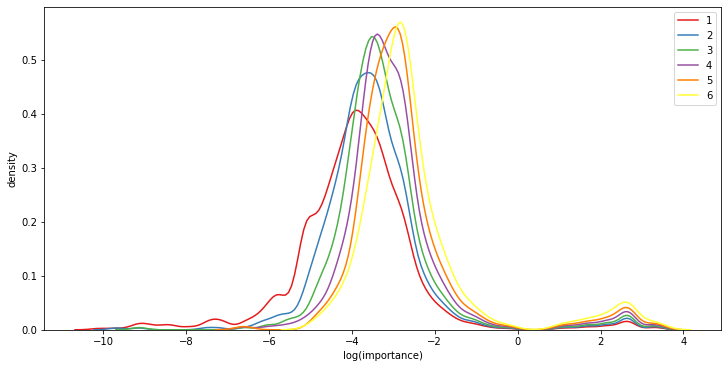

In [13]:
fig, ax1 = plt.subplots(figsize=(10, 5), layout='constrained')
fdrCalc.plot_log_densities(ax1, min_split_count=1, max_split_count=6, find_automatic_best=False)
plt.show()

In [ ]:
Step 9: This is a sanity check to visualize the splitcount was correct and consistent.

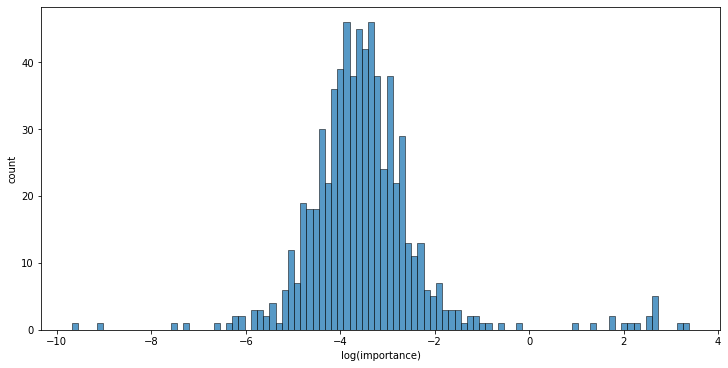

In [14]:
#Plot histogram for a selected threshold
fig, ax2 = plt.subplots(figsize=(10, 5), layout='constrained')
fdrCalc.plot_log_hist(ax2, split_count=2)
plt.show()

In [ ]:
Step 10: Compute the p-values, and the expected false discovery rate

In [15]:
#Get a table with the pvalues and the cutoff
pvalsDF, fdr = fdrCalc.compute_fdr(countThreshold = 2, cutoff = 0.05)
fdrDF, fdr

(           variant_id  logImportance        pvalue
 0     22_17705196_C_G      -9.685114  1.000000e+00
 1     22_17685358_C_T      -9.134216  1.000000e+00
 2    22_17774329_TC_T      -7.530889  9.999952e-01
 3     22_17763349_T_A      -7.214255  9.999780e-01
 4     22_17691887_C_T      -6.603883  9.996942e-01
 ..                ...            ...           ...
 682   22_16052838_T_A       2.698982  0.000000e+00
 683   22_16053509_A_G       2.703196  2.220446e-16
 684   22_16051480_T_C       2.732347  2.220446e-16
 685   22_16050678_C_T       3.224218  1.110223e-16
 686   22_16050408_T_C       3.387460  1.110223e-16
 
 [687 rows x 3 columns],
 0.021750802282878148)

In [ ]:
fdrDF[fdrDF.pvalue < fdr_corrected_cutoff]

In [24]:
hl.stop()

0.8133333333333334

In [28]:
a = pd.DataFrame({'a':[1,2,3],'b':[5,6,7]}).assign(x=[3,4,5],y=[9,5,6])
a

,a,b,x,y
0,1,5,3,9
1,2,6,4,5
2,3,7,5,6
